Notebook for generating files for NPTL data pipeline

In [3]:
%load_ext autoreload
%autoreload 2

import glob
import scipy.signal
import scipy.io
from scipy.signal import iirnotch, lfilter

import pickle as pkl
import numpy as np 
import json 

import re
import os

from read_emg import PreprocessedEMGDataset, PreprocessedSizeAwareSampler
import pickle

from absl import flags
from absl.flags import FLAGS
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TODO:
    
- try seeing if dataloader can be made faster/simpler using preprocessed files (maybe make a "PreprocessedEMGDataset" class)

In [4]:
import torch
DEVICE      = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
print('Using device: ', torch.cuda.get_device_name(DEVICE) if DEVICE != 'cpu' else 'CPU')

Using device:  Tesla V100-SXM2-32GB


In [5]:
import torch
from functools import lru_cache
from scipy.io import loadmat
from data_utils import phoneme_inventory, decollate_tensor, combine_fixed_length


In [6]:
from contrastive import ContrastiveLoss, DataAugmenter
from seqclr_model import SQNet, SimpleSQNet
import gc

gc.collect()
torch.cuda.empty_cache()
np.random.seed(42)       # make reproducible
torch.manual_seed(42)    # make reproducible

num_channels = 8
temperature  = 0.5

DEVICE   = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
model    = SimpleSQNet(num_channels, temporal_len = None)
loss_fcn = ContrastiveLoss(temperature= temperature, device = DEVICE)

# Using an Adam Optimizer
optim       = torch.optim.Adam(model.parameters(), lr = 0.001)
lr_sched    = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', 0.5, patience= 5)
print(model)
print('Using device: ', torch.cuda.get_device_name(DEVICE) if DEVICE != 'cpu' else 'CPU')
_ = model.to(DEVICE)

SimpleSQNet(
  (embed_model): Sequential(
    (0): ResBlock(
      (conv1): Conv1d(8, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (bn1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (residual_path): Conv1d(8, 768, kernel_size=(1,), stride=(2,))
      (res_norm): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (bn1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (residual_path): Conv1d(768, 768, kernel_size=(1,), stride

In [7]:
import glob

FLAGS = flags.FLAGS
FLAGS([''])

base_dir   = '/oak/stanford/projects/babelfish/magneto/GaddyPaper/processed_data/'
batch_size = 50

trainset = PreprocessedEMGDataset(base_dir = base_dir, train = True)
devset   = PreprocessedEMGDataset(base_dir = base_dir, dev = True)

train_dataloader    = torch.utils.data.DataLoader(trainset, pin_memory=(DEVICE.type == 'cuda'), 
                                                  collate_fn=trainset.collate_raw, 
                                                  num_workers=0, batch_size = batch_size)
dev_dataloader      = torch.utils.data.DataLoader(devset, pin_memory=(DEVICE.type == 'cuda'), 
                                                  collate_fn=devset.collate_raw, 
                                                  num_workers=0, batch_size = batch_size)

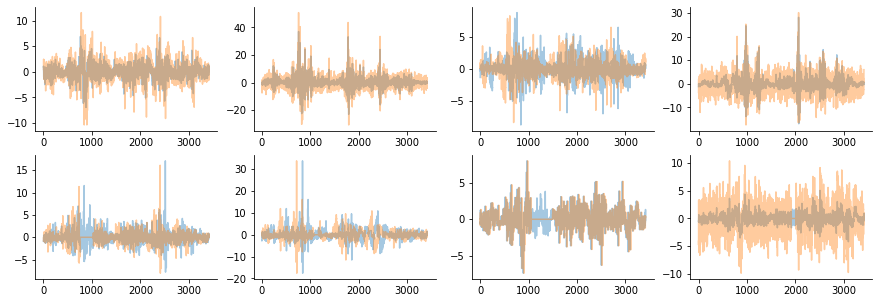

In [8]:
import matplotlib.pyplot as plt

num_augmentations = 3
augmentations     = {
                "amplitude_scale": [0.5, 2], 
                "time_shift": [-150, 150], 
                "DC_shift": [-5, 5], 
                "zero-masking": [0, 500], 
                "additive_Gaussian_noise": [0, 3], 
                "band-stop_filter": [2.8, 82.5],   }

augmenter = DataAugmenter(augmentations, num_augmentations=num_augmentations)
augmenter.get_augmentation_set()

dat      = trainset.__getitem__(3)
x, x_aug = augmenter.transform(dat['raw_emg'])

f, ax = plt.subplots(figsize=(15, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.plot(x[:, i], alpha = 0.4)
    plt.plot(x_aug[:, i], alpha = 0.4)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.show()

In [ ]:
def test(model, partition, device = 'cpu'):
    
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in partition:

                X_raw = combine_fixed_length([t.to(device, non_blocking=True) for t in batch['raw_emg']], seq_len)
                X_aug = combine_fixed_length([augmenter.transform(t)[1].to(device, non_blocking=True) for t in batch['raw_emg']], seq_len)

                loss  = loss_fcn(model(X_raw), model(X_aug))
                losses.append(loss.item())

    return np.mean(losses)

    

In [ ]:
import time, logging
from data_utils import combine_fixed_length

output_dir       = 'seqclr_output/'
n_epochs         = 80
seq_len          = 1000
warmup_batches   = 500
checkpoint_model = True


def set_lr(new_lr):
    for param_group in optim.param_groups:
        param_group['lr'] = new_lr

target_lr = 1e-3
def schedule_lr(iteration):
    iteration = iteration + 1
    if iteration <= warmup_batches:
        set_lr(iteration*target_lr/ warmup_batches)
        
        
logging.basicConfig(handlers=[
            logging.FileHandler(os.path.join(output_dir, 'log.txt'), 'w'),
            logging.StreamHandler()
            ], level=logging.INFO, format="%(message)s")



batch_idx = 0
for epoch_idx in range(n_epochs):
    losses = []
    loss   = 0    
    model.train()
    for batch in train_dataloader:
        
        optim.zero_grad()
        schedule_lr(batch_idx)

        X_raw = combine_fixed_length([t.to(DEVICE, non_blocking=True) for t in batch['raw_emg']], seq_len)
        X_aug = combine_fixed_length([augmenter.transform(t)[1].to(DEVICE, non_blocking=True) for t in batch['raw_emg']], seq_len)
        
        loss  = loss_fcn(model(X_raw), model(X_aug))
        losses.append(loss.item())

        loss.backward()
        optim.step()  
        batch_idx += 1 
                  
    train_loss = np.mean(losses)
    val        = test(model, dev_dataloader, DEVICE)
    lr_sched.step(val)
    logging.info(f'finished epoch {epoch_idx+1} - validation loss: {val:.4f} training loss: {train_loss:.4f}')
    if checkpoint_model:
        torch.save(model.embed_model.state_dict(), os.path.join(output_dir,'embed_model.pt'))

In [ ]:
with torch.no_grad():
    for batch in dev_dataloader:
        X_raw = combine_fixed_length([t.to(DEVICE, non_blocking=True) for t in batch['raw_emg']], seq_len)
        X_aug = combine_fixed_length([augmenter.transform(t)[1].to(DEVICE, non_blocking=True) for t in batch['raw_emg']], seq_len)

        pred_orig = model(X_raw).detach().cpu()
        pred_aug  = model(X_aug).detach().cpu()
        break

In [ ]:
%matplotlib inline
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns

f, ax = plt.subplots(figsize=(20, 10))

n_examples = pred_orig.shape[0]

plt.subplot(1, 2, 1)
dists = squareform(pdist(np.vstack([pred_orig, pred_aug]), metric = 'cosine'))
im    = plt.imshow(dists, vmin = 0)
plt.colorbar(im,fraction=0.046, pad=0.04)


plt.subplot(1, 2, 2)
match    = np.diag(dists[:n_examples, n_examples:])[:]
match    = match[match != 0]
nonmatch = np.triu(dists[:n_examples, n_examples:])[:]
nonmatch = nonmatch[nonmatch != 0 ]
nonmatch_orig = np.triu(dists[:n_examples, :n_examples])[:]
nonmatch_orig = nonmatch_orig[nonmatch_orig != 0]
sns.violinplot(data = [match, nonmatch, nonmatch_orig],)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['Positive pair match', 'Positive pair nonmatch', 'Negative pair nonmatch'])
ax.set_ylabel('Euclidean distance')
plt.show()

In [22]:
import torch
from transduction_model import Model

FLAGS = flags.FLAGS
FLAGS([''])

model_dir = '/oak/stanford/projects/babelfish/magneto/GaddyPaper/pretrained_models/transduction_model.pt'
model     = Model(8, 80, 48).to(DEVICE)
model.load_state_dict(torch.load(model_dir))


<All keys matched successfully>

In [23]:
x_raw = X_raw.transpose(1,2) # put channel before time for conv
x_raw = model.conv_blocks(x_raw)

In [24]:
x_raw.shape

torch.Size([161, 768, 200])

In [25]:
X_raw.shape

torch.Size([161, 1600, 8])

In [19]:
for batch in train_dataloader:
    X_raw = combine_fixed_length([t.to(DEVICE, non_blocking=True) for t in batch['raw_emg']], 1600)
    
    

KeyboardInterrupt: 